<a href="https://colab.research.google.com/github/wanickols01/LearningMLandDL/blob/main/FinalProjectAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


In [3]:
#Imports
import seaborn as sns
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Mount Google Drive
try:
    drive.mount("/content/drive")
except:
    print("Google Drive already mounted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [5]:
#Set File name
filename = "/content/drive/My Drive/Colab Notebooks/Data/mammographic_masses.data.txt" ##### IMPORTANT #####, This is a file path that is unique to my google drive.
col_names = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]
data = pd.read_csv(filename, header=None, names=col_names)
print(data) 

    BI-RADS Age Shape Margin Density  Severity
0         5  67     3      5       3         1
1         4  43     1      1       ?         1
2         5  58     4      5       3         1
3         4  28     1      1       3         0
4         5  74     1      5       ?         1
..      ...  ..   ...    ...     ...       ...
956       4  47     2      1       3         0
957       4  56     4      5       3         1
958       4  64     4      5       3         0
959       5  66     4      5       3         1
960       4  62     3      3       3         0

[961 rows x 6 columns]


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [6]:
# Replace ? with nan and print missing values
data = pd.read_csv(filename, header=None, names=col_names, na_values='?')
print(data)
missing_values = data.isna().sum()
print(missing_values)

     BI-RADS   Age  Shape  Margin  Density  Severity
0        5.0  67.0    3.0     5.0      3.0         1
1        4.0  43.0    1.0     1.0      NaN         1
2        5.0  58.0    4.0     5.0      3.0         1
3        4.0  28.0    1.0     1.0      3.0         0
4        5.0  74.0    1.0     5.0      NaN         1
..       ...   ...    ...     ...      ...       ...
956      4.0  47.0    2.0     1.0      3.0         0
957      4.0  56.0    4.0     5.0      3.0         1
958      4.0  64.0    4.0     5.0      3.0         0
959      5.0  66.0    4.0     5.0      3.0         1
960      4.0  62.0    3.0     3.0      3.0         0

[961 rows x 6 columns]
BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [7]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [8]:
data_mean = data
data_median = data

# Calculate the mean of the Shape and Margin columns
br_mean = data['BI-RADS'].mean()
age_mean = data['Age'].mean()
shape_mean = data['Shape'].mean()
margin_mean = data['Margin'].mean()
density_mean = data['Density'].mean()

# Replace missing values with the mean value
data_mean['BI-RADS'].fillna(br_mean, inplace=True)
data_mean['Age'].fillna(age_mean, inplace=True)
data_mean['Shape'].fillna(shape_mean, inplace=True)
data_mean['Margin'].fillna(margin_mean, inplace=True)
data_mean['Density'].fillna(density_mean, inplace=True)


# Calculate the median of the Shape and Margin columns
br_median = data['BI-RADS'].median()
age_median = data['Age'].median()
shape_median = data['Shape'].median()
margin_median = data['Margin'].median()
density_median = data['Density'].median()

# Replace missing values with the median value

data_median['BI-RADS'].fillna(br_median, inplace=True)
data_median['Age'].fillna(age_median, inplace=True)
data_median['Shape'].fillna(shape_median, inplace=True)
data_median['Margin'].fillna(margin_median, inplace=True)
data_median['Density'].fillna(density_median, inplace=True)

#Print Describes
print(data_mean.describe())
print(data_median.describe())

#Double Check Missing Values
missing_values = data_mean.isna().sum()
print(missing_values)

missing_values = data_median.isna().sum()
print(missing_values)

          BI-RADS         Age       Shape      Margin     Density    Severity
count  961.000000  961.000000  961.000000  961.000000  961.000000  961.000000
mean     4.348279   55.487448    2.721505    2.796276    2.910734    0.463059
std      1.781173   14.442373    1.222561    1.526880    0.365074    0.498893
min      0.000000   18.000000    1.000000    1.000000    1.000000    0.000000
25%      4.000000   45.000000    2.000000    1.000000    3.000000    0.000000
50%      4.000000   57.000000    3.000000    3.000000    3.000000    0.000000
75%      5.000000   66.000000    4.000000    4.000000    3.000000    1.000000
max     55.000000   96.000000    4.000000    5.000000    4.000000    1.000000
          BI-RADS         Age       Shape      Margin     Density    Severity
count  961.000000  961.000000  961.000000  961.000000  961.000000  961.000000
mean     4.348279   55.487448    2.721505    2.796276    2.910734    0.463059
std      1.781173   14.442373    1.222561    1.526880    0.36507

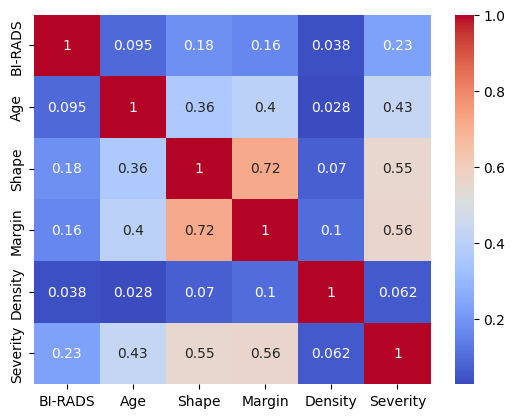

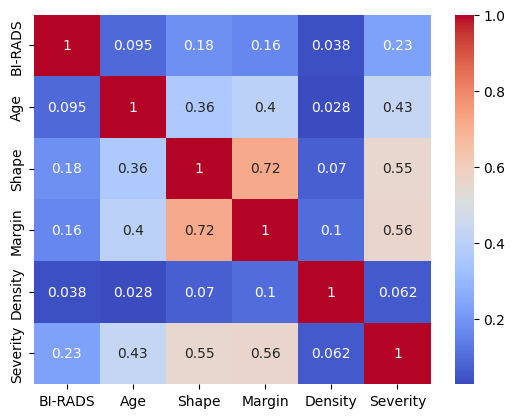

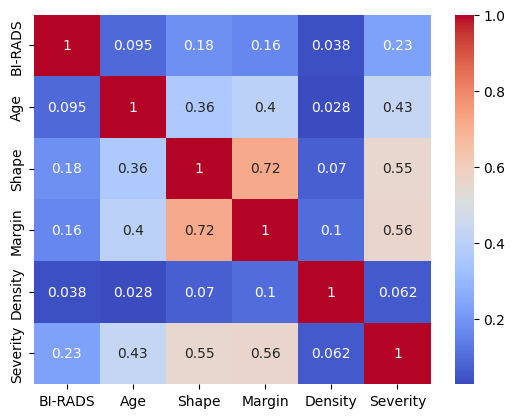

In [7]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Compute the correlation matrix
corr_matrix = data_mean.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

corr_matrix = data_median.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [9]:
data.dropna()

missing_values = data.isna().sum()
print(missing_values)

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [11]:
import sklearn.model_selection as model_selection 

features = data.columns[1:5]

X = data[features].values
y = data['Severity']

target = y;

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size =0.75, test_size =0.25, random_state =42)
#Split data into training and testing

print(features)


Index(['Age', 'Shape', 'Margin', 'Density'], dtype='object')


Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [12]:
from sklearn.preprocessing import StandardScaler

#Create Scalar and fit it based on training data
scaler = StandardScaler()
scaler.fit(X_train)

#Normalize training data and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [11]:
#printing these since I already did that
print(X_train_scaled)
print(X_test_scaled)

[[-0.72864846 -1.4058912  -1.18215137  0.22254945]
 [-0.04845877  1.06035197  0.77952473  0.22254945]
 [-0.86468639  0.23827091  0.77952473 -0.01988769]
 ...
 [ 0.42767401  1.06035197  1.43341677  0.22254945]
 [ 0.83578782  1.06035197  1.43341677  0.22254945]
 [ 0.15559813  1.06035197  0.77952473 -0.01988769]]
[[ 0.42767401 -1.4058912  -1.18215137  0.22254945]
 [-0.38855361  1.06035197  0.1256327   0.22254945]
 [-1.13676227  1.06035197  0.1256327  -0.01988769]
 [-1.54487608 -1.4058912  -1.18215137  0.22254945]
 [-1.40883814  1.06035197 -0.52825934 -0.01988769]
 [-0.11647774  1.06035197  0.1256327   0.22254945]
 [-0.66062949 -1.4058912  -1.18215137  0.22254945]
 [-0.18449671 -1.4058912  -1.18215137  0.22254945]
 [ 0.15559813  1.06035197  0.77952473  0.22254945]
 [ 1.17588266  1.06035197  0.1256327   0.22254945]
 [ 0.56371194 -1.4058912  -1.18215137  0.22254945]
 [ 1.10786369  1.06035197  0.1256327  -0.01988769]
 [-0.86468639  1.06035197  1.43341677 -0.01988769]
 [-0.59261052 -0.58381014

Now create a DecisionTreeClassifier and fit it to your training data.

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier() # creataes tree
clf = clf.fit(X,y) #fits to data

Display the resulting decision tree.

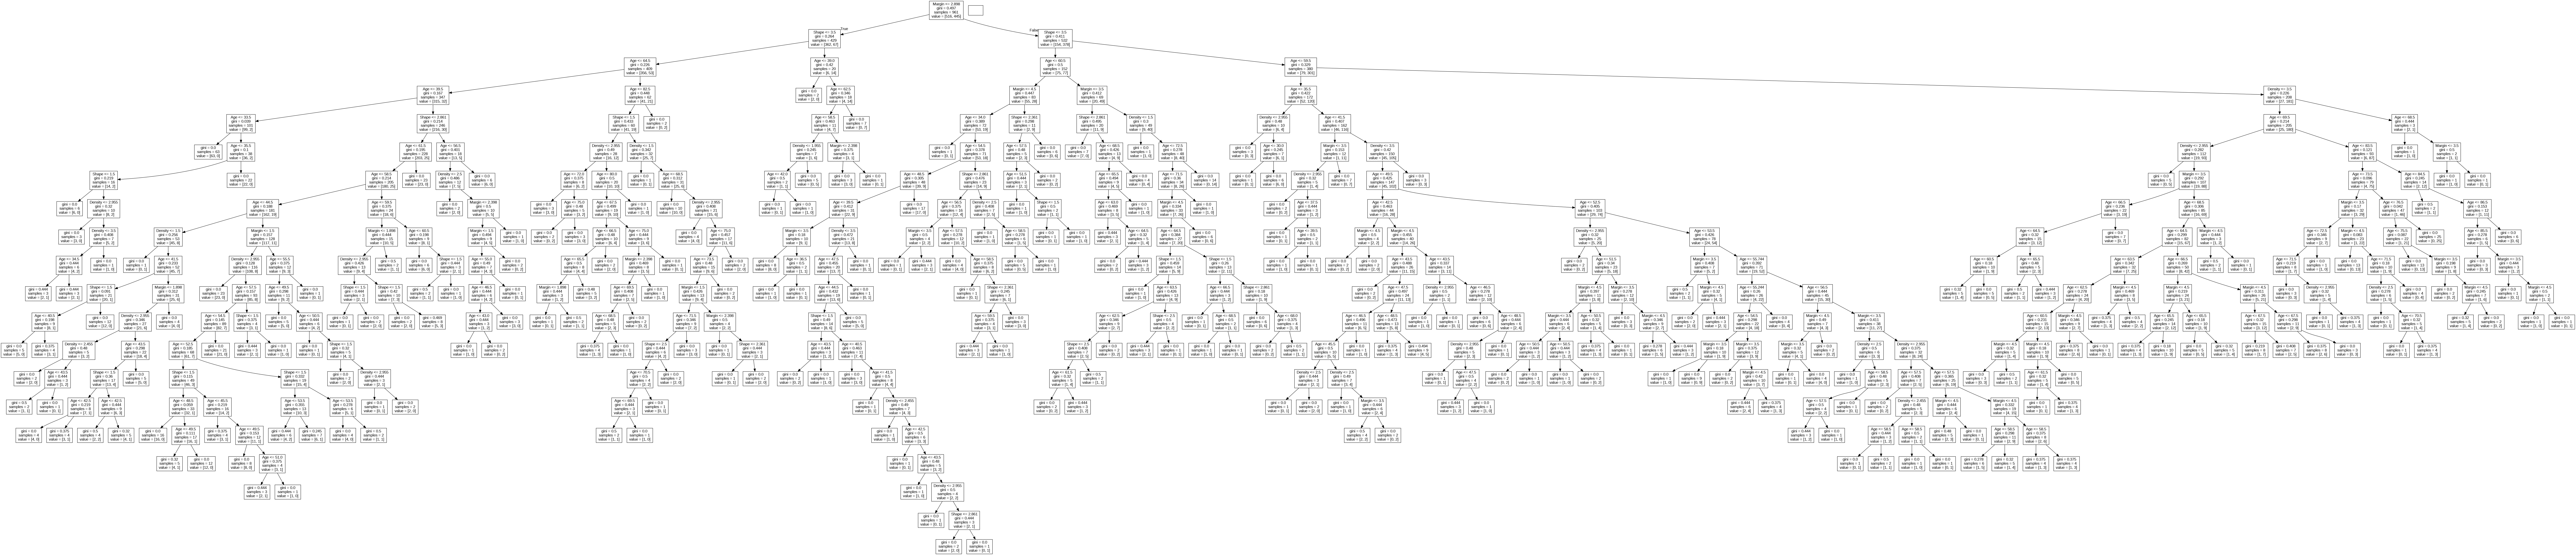

In [13]:
from IPython.display import Image  
from six import StringIO  
import pydotplus
#Code to display tree 
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

#gini = entropy value
#samples = remaining samples without an offer
#value how many were hired or no hired

Measure the accuracy of the resulting decision tree model using your test data.

In [14]:
from sklearn import metrics

y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.91701244813278


#### Data with dropna ACC = .0.91701244813278
#### Data with mean replacement = 0.91701244813278
#### Data with median replacement 0.91701244813278

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [16]:
from sklearn.model_selection import cross_val_score, train_test_split

# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(clf, X, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all 5 folds:
print(scores.mean())


[0.77319588 0.72916667 0.72916667 0.83333333 0.8125     0.83333333
 0.66666667 0.79166667 0.78125    0.71875   ]
0.7669029209621994


#### Data with dropna ACC = 0.7367590206185567
#### Data with mean replacement = N/A
#### Data with median replacement 0.7326030927835052

Now try a RandomForestClassifier instead. Does it perform better?

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

scores = cross_val_score(clf, X, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all 5 folds:
print(scores.mean())

NameError: ignored

#### Data with dropna ACC = 0.7617160652920962
#### Data with mean replacement = N/A
#### Data with median replacement 0.7326030927835052

> Decided to go with dropna for rest of test



## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, datasets


scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
X = scaling.transform(X)

C = 1.0
svc = svm.SVC(kernel='rbf', C=C).fit(X, y) #specify kernal

print(X)



[[ 0.25641026  0.33333333  1.          0.33333333]
 [-0.35897436 -1.         -1.          0.27382298]
 [ 0.02564103  1.          1.          0.33333333]
 ...
 [ 0.17948718  1.          1.          0.33333333]
 [ 0.23076923  1.          1.          0.33333333]
 [ 0.12820513  0.33333333  0.          0.33333333]]


In [19]:
cv_scores = cross_val_score(svc, X, y, cv=10)

cv_scores.mean()

0.8074742268041236

In [20]:
#Reverse MinMax
X = scaling.inverse_transform(X)

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def create_knn(k):
  # Create the KNN classifier
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the model
  knn.fit(X_train, y_train)

  # Predict the classes of the test set
  y_pred = knn.predict(X_test)

  # Calculate the accuracy of the model
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

create_knn(5)

0.7593360995850622

#### Accuracy: 759 

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [22]:
max = 0.0;
maxK = 0;
for k in range(1, 50):
    accuracy = create_knn(k)
    if(accuracy > max):
      max = accuracy
      maxK = k
      print("k =", k, "accuracy = ", accuracy)
    

print("best k = ", maxK, "Max Accuracy =", max)

k = 1 accuracy =  0.7261410788381742
k = 3 accuracy =  0.7468879668049793
k = 5 accuracy =  0.7593360995850622
k = 11 accuracy =  0.7634854771784232
k = 13 accuracy =  0.7676348547717843
k = 17 accuracy =  0.7800829875518672
k = 21 accuracy =  0.7883817427385892
best k =  21 Max Accuracy = 0.7883817427385892


#### Max accuracy is .7883 using k = 21

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Naive Bayes Multinomial model
nb = MultinomialNB()
nb.fit(X_train_scaled, y_train)

# Predict the classes of the test set
y_pred = nb.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7676348547717843


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

0.8215767634854771


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8215767634854771


#### 82.15 % New winner!

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.decomposition import PCA
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(8, input_shape=(4,), activation='relu'))
model.add(Dense(1, activation='sigmoid')) # output layer with 1 binary output neuron


In [35]:

optimizer = Adam(lr=0.001, ) # set the learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

This will print out your devices. If you don't see a gpu you make sure you change runtime to include one, you need the time

In [36]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2354413377294316493
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13325721364485902465
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [38]:
#Train
model.fit(X_train, y_train,
          batch_size = 128,
          epochs=20,
          verbose=2,
          validation_split=0.2,
          validation_data=(X_test, y_test)
          )

Epoch 1/20
6/6 - 0s - loss: 0.5594 - accuracy: 0.7514 - val_loss: 0.5483 - val_accuracy: 0.7718 - 351ms/epoch - 58ms/step
Epoch 2/20
6/6 - 0s - loss: 0.5593 - accuracy: 0.7500 - val_loss: 0.5463 - val_accuracy: 0.7842 - 383ms/epoch - 64ms/step
Epoch 3/20
6/6 - 0s - loss: 0.5557 - accuracy: 0.7556 - val_loss: 0.5455 - val_accuracy: 0.8008 - 419ms/epoch - 70ms/step
Epoch 4/20
6/6 - 0s - loss: 0.5555 - accuracy: 0.7736 - val_loss: 0.5469 - val_accuracy: 0.7925 - 438ms/epoch - 73ms/step
Epoch 5/20
6/6 - 1s - loss: 0.5550 - accuracy: 0.7722 - val_loss: 0.5454 - val_accuracy: 0.8091 - 792ms/epoch - 132ms/step
Epoch 6/20
6/6 - 1s - loss: 0.5540 - accuracy: 0.7750 - val_loss: 0.5435 - val_accuracy: 0.8008 - 882ms/epoch - 147ms/step
Epoch 7/20
6/6 - 1s - loss: 0.5531 - accuracy: 0.7736 - val_loss: 0.5427 - val_accuracy: 0.8008 - 839ms/epoch - 140ms/step
Epoch 8/20
6/6 - 1s - loss: 0.5526 - accuracy: 0.7681 - val_loss: 0.5421 - val_accuracy: 0.8008 - 814ms/epoch - 136ms/step
Epoch 9/20
6/6 - 0s 

I played around with alot, the highest I got was a little over 80%

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

These were all fairly close, except decision trees, and I would personally use Logistic regression given how simple it is and it had the best average result.